# 2. DETECÇÃO DE FRAUDES COM REGRESSÃO LOGÍSTICA

# === IMPORTAÇÃO DE BIBLIOTECAS ===

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score,
    make_scorer, RocCurveDisplay
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. CARGA DO DATASET ===

In [2]:
df = pd.read_csv("creditcard.csv")
print("Total de transações:", len(df))
print("Total de fraudes:", df['Class'].sum())


Total de transações: 284807
Total de fraudes: 492


# === 2. PRÉ-PROCESSAMENTO ===

In [3]:
X = df.drop("Class", axis=1)
y = df["Class"]

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balanceamento com SMOTE

In [5]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])

## Validação Cruzada

In [6]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

# Validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n=== Validação Cruzada (média das métricas) ===")
for metric_name, scorer in scoring.items():
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scorer, n_jobs=-1)
    print(f"{metric_name.upper()}: {cv_scores.mean():.4f}")


=== Validação Cruzada (média das métricas) ===
ACCURACY: 0.9910
PRECISION: 0.1483
RECALL: 0.8902
F1: 0.2541
ROC_AUC: 0.9789


# Divisão treino/teste

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# === 3. MODELO REGRESSÃO LOGÍSTICA ===

In [9]:
lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]

# === 4. AVALIAÇÃO ===

In [10]:
print("\n=== MATRIZ DE CONFUSÃO ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"\n=== ROC-AUC: {auc:.4f} ===")


=== MATRIZ DE CONFUSÃO ===
[[56851    13]
 [   34    64]]

=== RELATÓRIO DE CLASSIFICAÇÃO ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962


=== ROC-AUC: 0.9485 ===


# Curva ROC

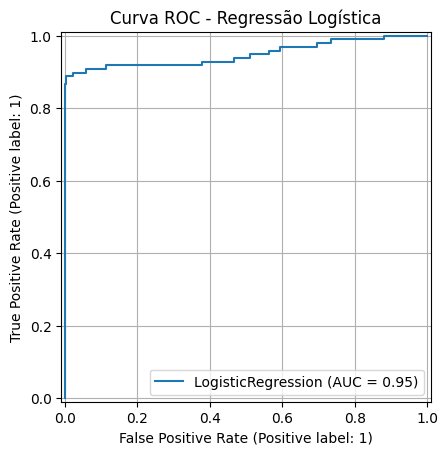

In [11]:
RocCurveDisplay.from_estimator(lr_model, X_test, y_test)
plt.title("Curva ROC - Regressão Logística")
plt.grid(True)
plt.show()

# Heatmap da matriz de confusão

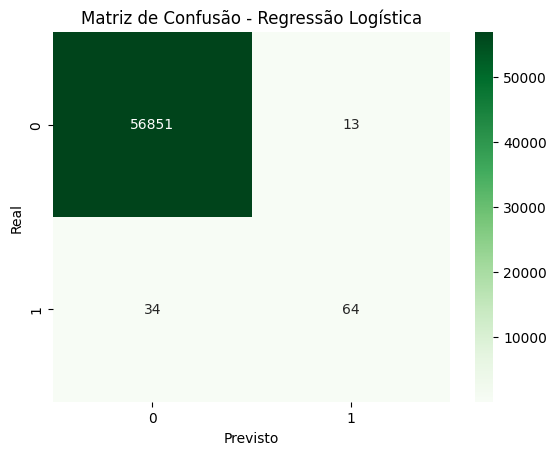

In [12]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusão - Regressão Logística")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()
